# **Step-by-Step R-CNN Implementation**

Classification and object detection are the main parts of computer vision. Classification is finding what is in an image and object detection and localisation is finding where is that object in that image. Detection is a more complex problem to solve as we need to find the coordinates of the object in an image.

In R-CNN instead of running classification on huge number of regions we pass the image through selective search and select first 2000 region proposal from the result and run classification on that. In this way instead of classifying huge number of regions we need to just classify first 2000 regions. This makes this algorithm fast compared to previous techniques of object detection

Connect with your google drive if using colab notebook

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive




####]]]]]]]]]]]][##'Make a directory to unzip the dataset i.e. Airplane Images and Annotations.

In [ ]:
#!mkdir /content/gdrive/My\ Drive/AI341_Lab/Object_Detection/Images

In [ ]:
#!unzip -q "/content/gdrive/MyDrive/AI341_Lab/Object_Detection/Images.zip" -d "/content/gdrive/MyDrive/AI341_Lab/Object_Detection/Images"

In [ ]:
#!unzip -q "/content/gdrive/MyDrive/AI341_Lab/Object_Detection/Airplanes_Annotations.zip" -d "/content/gdrive/MyDrive/AI341_Lab/Object_Detection/Airplanes_Annotations"

**Import the libraries**
First step is to import all the libraries which will be needed to implement R-CNN. We need cv2 to perform selective search on the images. 

In [2]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
path = '/content/gdrive/MyDrive/ML_Lab_Data/Images'                 # path to images
annot = '/content/gdrive/MyDrive/ML_Lab_Data/AirplanesAnnotations'  # path to annotations

Draw one sample image and the bounding box from the given annotation files

428461.jpg


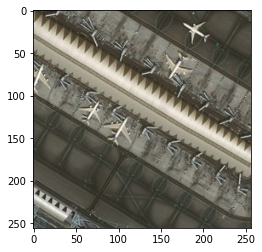

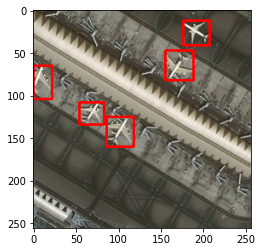

In [4]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

We need cv2 to perform selective search on the images. To use selective search we need to download opencv-contrib-python. To download that just run *pip install opencv-contrib-python* in the terminal and install it from pypi.

We need to initialise selective search.

In [5]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

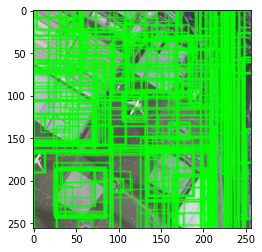

In [6]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [7]:
train_images=[]     
train_labels=[]

Now we are initialising the function to calculate IOU (Intersection Over Union) of the ground truth box from the box computed by selective search.

In [8]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [9]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

The given code is pre-processing and creating the data-set to pass to the model. As in this case we can have 2 classes. These classes are that whether the proposed region can be a foreground (i.e. Airplane) or a background. So we will set the label of foreground (i.e. Airplane) as 1 and the label of background as 0. The following steps are being performed in the above code block.

1. Loop over the image folder and set each image one by one as the base for 
selective search using code ss.setBaseImage(image)
2. Initialising fast selective search and getting proposed regions using using code ss.switchToSelectiveSearchFast() and ssresults = ss.process()
3. Iterating over all the first 2000 results passed by selective search and calculating IOU of the proposed region and annotated region using the get_iou() function created above.
4. Now as one image can many negative sample (i.e. background) and just some positive sample (i.e. airplane) so we need to make sure that we have good proportion of both positive and negative sample to train our model. Therefore we have set that we will collect maximum of 30 negative sample (i.e. background) and positive sample (i.e. airplane) from one image.

After running the above code snippet our training data will be ready. List train_images=[] will contain all the images and train_labels=[] will contain all the labels marking airplane images as 1 and non airplane images (i.e. background images) as 0.

In [10]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

2 airplane_007.jpg
inside
4 airplane_005.jpg
inside
7 airplane_008.jpg
10 airplane_001.jpg
inside
12 airplane_004.jpg
inside
16 airplane_002.jpg
17 airplane_006.jpg
19 airplane_003.jpg


After completing the process of creating the dataset we will convert the array to numpy array so that we can traverse it easily and pass the datatset to the model in an efficient way.

In [11]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [12]:
X_new.shape

(386, 224, 224, 3)

Now we will do transfer learning on the imagenet weight. We will import VGG16 model and also put the imagenet weight in the model.

In [13]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In this part in the loop we are freezing the first 15 layers of the model. After that we are taking out the second last layer of the model and then adding a 2 unit softmax dense layer as we have just 2 classes to predict i.e. foreground or background. After that we are compiling the model using Adam optimizer with learning rate of 0.001. We are using categorical_crossentropy as loss since the output of the model is categorical. Finally the summary of the model will is printed using model_final.summary(). The image of summary is attached below.

In [14]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [ ]:
X= vggmodel.layers[-2].output

In [ ]:
predictions = Dense(2, activation="softmax")(X)

In [ ]:
model_final = Model( vggmodel.input,  predictions)

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [ ]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

After creating the model now we need to split the dataset into train and test set. Before that we need to one-hot encode the label. For that we are using MyLabelBinarizer() and encoding the dataset. Then we are splitting the dataset using train_test_split from sklearn. We are keeping 10% of the dataset as test set and 90% as training set.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(347, 224, 224, 3) (39, 224, 224, 3) (347, 2) (39, 2)


Now we will use Keras ImageDataGenerator to pass the dataset to the model. We will do some augmentation on the dataset like horizontal flip, vertical flip and rotation to increase the dataset.

In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

Now we start the training of the model using fit_generator.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 5, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

<ipython-input-35-fc6a2c5c78dd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 5, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 1.0835 - accuracy: 0.7873 
Epoch 1: val_loss improved from inf to 0.50067, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 263s 26s/step - loss: 1.0835 - accuracy: 0.7873 - val_loss: 0.5007 - val_accuracy: 0.8974
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.9270 
Epoch 2: val_loss improved from 0.50067 to 0.30113, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 247s 25s/step - loss: 0.1968 - accuracy: 0.9270 - val_loss: 0.3011 - val_accuracy: 0.8974
Epoch 3/5
10/10 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9143 
Epoch 3: val_loss did not improve from 0.30113
10/10 [==============================] - 237s 24s/step - loss: 0.2066 - accuracy: 0.9143 - val_loss: 0.4589 - val_accuracy: 0.8974
Epoch 4/5
10/10 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9333 
Epoch 4: val

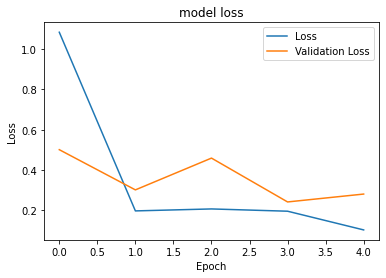

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

1/1 [==============================] - 1s 841ms/step
plane


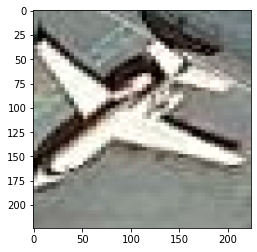

In [ ]:
im = X_test[8]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

Now that we have created the model. 
Your task is to do prediction on that model. For that we need to follow the steps mentioned below :

1. pass the image from selective search.
2. pass all the result of the selective search to the model as input using *model_final.predict(img)*.
3. If the output of the model says the region to be a foreground image (i.e. airplane image) and if the confidence is above the defined threshold then create bounding box on the original image on the coordinate of the proposed region.

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

NameError: ignored

In [ ]:
im = X_test[2]
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

NameError: ignored

InvalidArgumentError: ignored

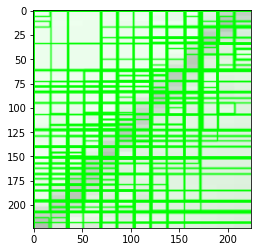

In [ ]:
plt.imshow(imOut)
img = np.expand_dims(imOut, axis=0)
out= model_final.predict(imOut)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")